In [294]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import pickle
import time
tqdm.pandas()
sns.set_style("whitegrid")
%config InlineBackend.figure_formats = ['svg']

# Models
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier

# Metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score

In [295]:
# Load the dataset
LEVEL = "small"
TRAIN_PATH = f"../data/normalize/normalized-train-ugr16-{LEVEL}.csv"
TEST_PATH = f"../data/normalize/normalized-test-ugr16-{LEVEL}.csv"

data_df = pd.read_csv(TRAIN_PATH, index_col=0)
test_df = pd.read_csv(TEST_PATH, index_col=0)

In [296]:
LABEL_COLUMN_LIST = data_df.columns[data_df.columns.str.startswith("label")]
label_serie = data_df[LABEL_COLUMN_LIST].idxmax(axis=1)

In [297]:
# Split TRAIN/VALIDATION
train_df, validation_df = train_test_split(data_df, test_size=0.1, shuffle=True, stratify=label_serie)

In [298]:
def get_input_target(data_df):
    return data_df.drop(columns=LABEL_COLUMN_LIST), data_df[LABEL_COLUMN_LIST]

In [299]:
x_train, y_train = get_input_target(train_df)
x_validation, y_validation = get_input_target(validation_df)
x_test, y_test = get_input_target(test_df)

## Multi-model benchmark

In [300]:
model_dict = dict()
model_dict["DecisionTreeClassifier"] = DecisionTreeClassifier(max_depth=25)
model_dict["RandomForestClassifier"] = RandomForestClassifier(max_depth=10)
model_dict["LogisticRegression"] = LogisticRegression(max_iter=1000)
model_dict["GaussianNB"] = GaussianNB()
model_dict["SGDClassifier"] = SGDClassifier()
model_dict["SVC"] = SVC()
model_dict["XGBClassifier"] = xgb.XGBClassifier(n_estimators=500, max_depth=10, 
                                                learning_rate=0.01, early_stopping_rounds=20)
model_dict["AdaBoostClassifier"] = AdaBoostClassifier(n_estimators=100, 
                                                      base_estimator=DecisionTreeClassifier(max_depth=10),
                                                      learning_rate=1)

In [301]:
# Le modèle prend x et donne l'ID de la classe LABEL
# Dans la dataset, on a appliqué du OneHotEncoding par défaut
# Certains algos comme GaussianNB ont besoin d'avoir
# juste l'ID comme target et non pas un vecteur OneHot
# Comme les autres algo sont compatibles, on va donc
# y_train [OneHot] -> to_label_category [Id categorie]
# Et à la prédiction
# y_pred [Id categorie] -> to_one_hot [OneHot]
# pour le comparer au y_test [OneHot] de la dataset

def to_label_category(y_set):
    return LABEL_COLUMN_LIST.get_indexer(y_set.idxmax(axis=1))

def to_one_hot(y_set):
    vect = np.zeros((len(y_set), len(LABEL_COLUMN_LIST)))
    vect[np.arange(len(y_set)), y_set] = 1
    return vect

In [302]:
def train_sklearn_model(model_name, model):
    # train
    model.fit(x_train, to_label_category(y_train))

    # save
    with open(f"export/model_{model_name}_{LEVEL}.pck", "wb") as f:
        pickle.dump(model, f)

def train_xgboost_model(model_name, model):
    # train
    model.fit(x_train, to_label_category(y_train), 
            eval_set=[(x_train, to_label_category(y_train)),
                      (x_validation, to_label_category(y_validation))])
    # save
    model.save_model(f"export/model_{model_name}_{LEVEL}.json")

In [303]:
def draw_confusion_matrix(model_name, y_true, y_pred):
    cf_matrix = confusion_matrix(y_pred.argmax(axis=1), y_true.values.argmax(axis=1))
    cf_matrix_df = pd.DataFrame(cf_matrix, 
        index=LABEL_COLUMN_LIST, 
        columns=LABEL_COLUMN_LIST)
    norm_cf_matrix_df = cf_matrix_df/cf_matrix_df.sum(axis=0)

    plt.figure(figsize=(10,10))
    g = sns.heatmap(norm_cf_matrix_df,
                annot=True,
                fmt='.3f',
                cmap='rocket_r')
    g.set_xlabel("Vraie classe")
    g.set_ylabel("Classe prédite par le modèle")
    g.set_title(f"Matrice de confusion avec {model_name} (en proportion d'exemples)[{LEVEL}]")
    plt.savefig(f"graph/cf-matrix_{model_name}_{LEVEL}.svg", bbox_inches='tight')
    plt.show()

def compute_score(y_true, y_pred):
    score_dict = dict()
    score_dict["accuracy_score"] = accuracy_score(y_true, y_pred)
    score_dict["f1_score"] = f1_score(y_true, y_pred, average="micro")
    score_dict["roc_auc_score"] = roc_auc_score(y_true, y_pred)
    score_dict["precision_score"] = precision_score(y_true, y_pred, average="micro")
    score_dict["recall_score"] = recall_score(y_true, y_pred, average="micro")
    return score_dict

def evaluation(model_name, model):
    y_pred = model.predict(x_test)
    y_pred = to_one_hot(y_pred)
    score = compute_score(y_test, y_pred)
    draw_confusion_matrix(model_name, y_test, y_pred)
    return score

  0%|          | 0/8 [00:00<?, ?it/s]

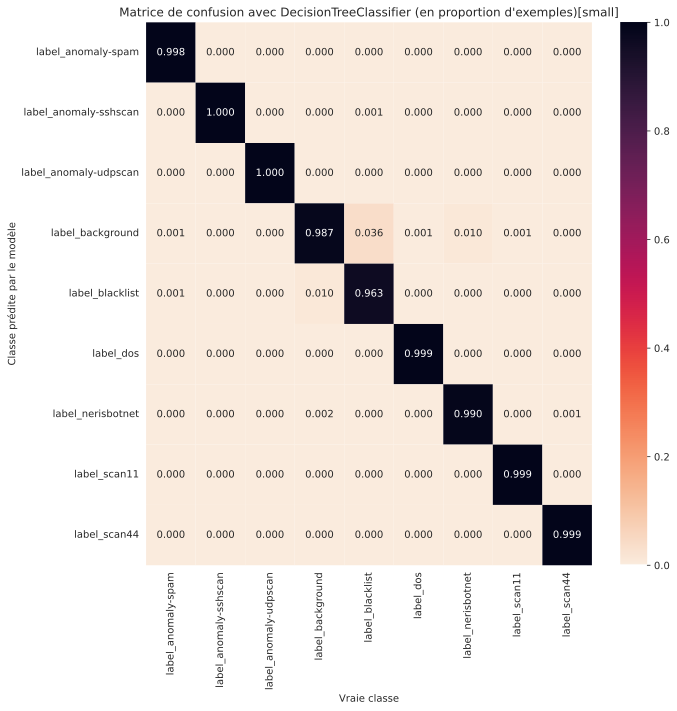

model_name='DecisionTreeClassifier' | accuracy=0.9904166666666666 | f1=0.9904166666666666 | auroc=0.9956702674897119


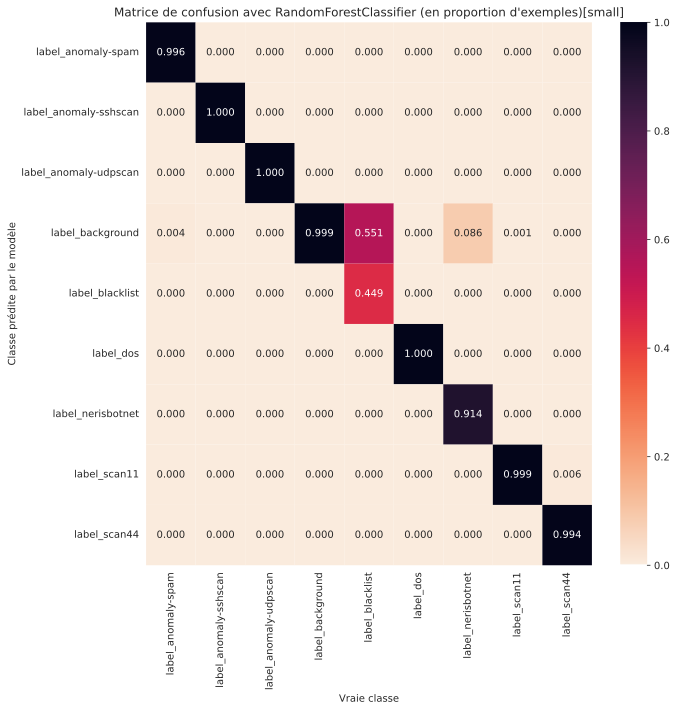

model_name='RandomForestClassifier' | accuracy=0.9591666666666666 | f1=0.9591666666666666 | auroc=0.9594727366255145


/home/nigiva/projet/epita/mlsecu/projet/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


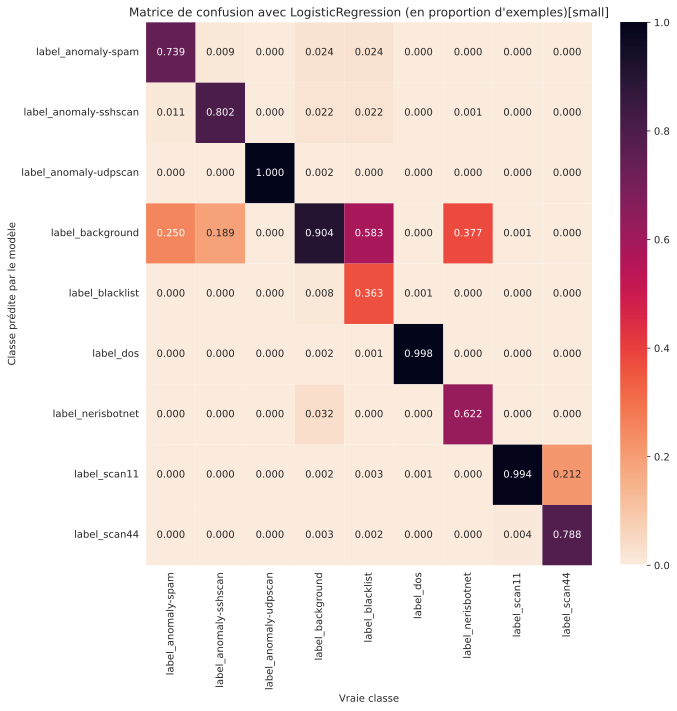

model_name='LogisticRegression' | accuracy=0.84625 | f1=0.84625 | auroc=0.8869537037037037


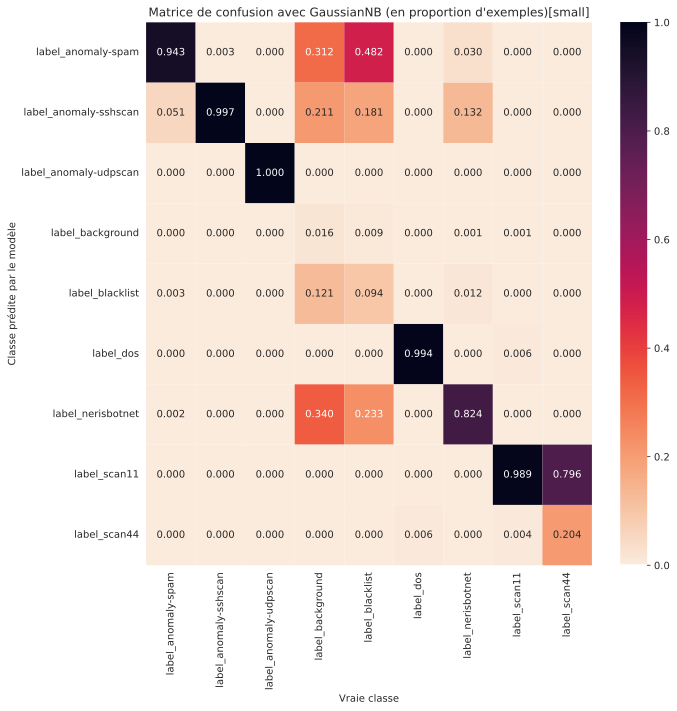

model_name='GaussianNB' | accuracy=0.3859722222222222 | f1=0.38597222222222227 | auroc=0.800398148148148


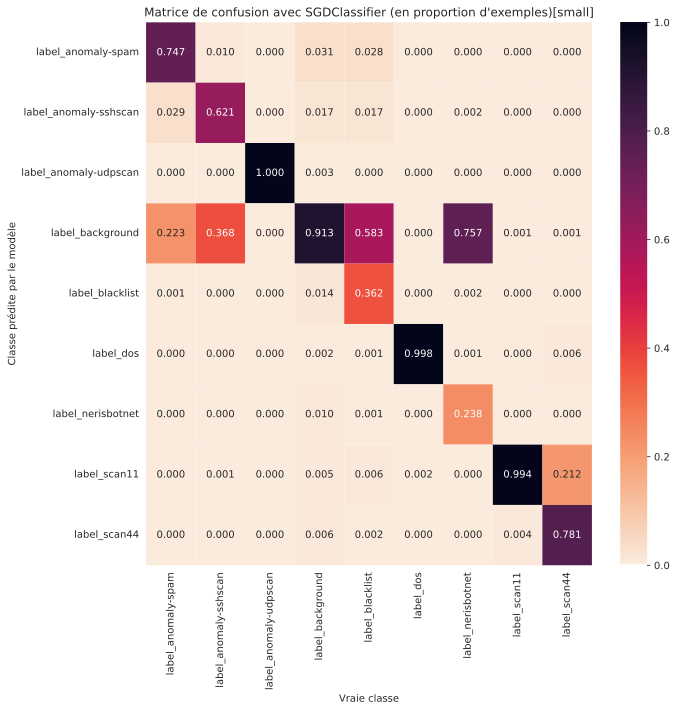

model_name='SGDClassifier' | accuracy=0.8155555555555556 | f1=0.8155555555555555 | auroc=0.8525036008230453


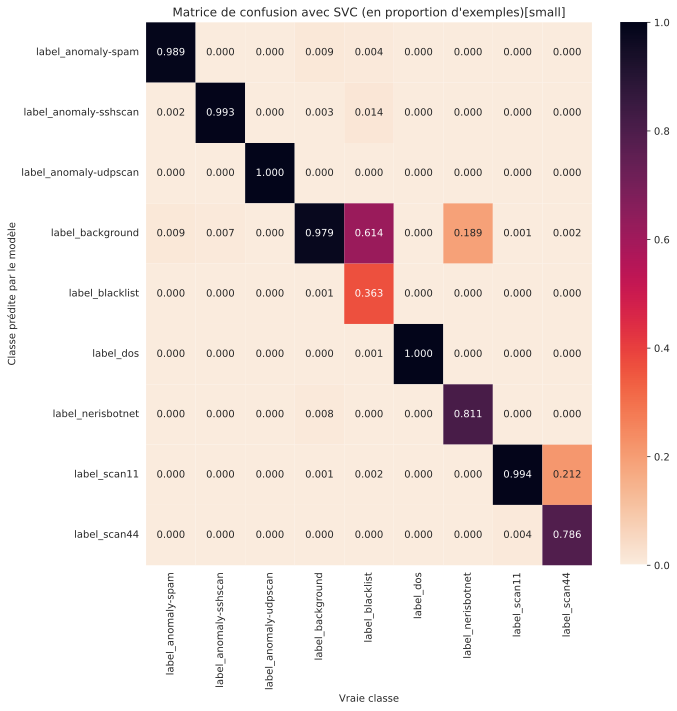

model_name='SVC' | accuracy=0.9228472222222223 | f1=0.9228472222222223 | auroc=0.9325010288065845
[0]	validation_0-mlogloss:2.15420	validation_1-mlogloss:2.15426
[1]	validation_0-mlogloss:2.11305	validation_1-mlogloss:2.11315
[2]	validation_0-mlogloss:2.07361	validation_1-mlogloss:2.07375
[3]	validation_0-mlogloss:2.03574	validation_1-mlogloss:2.03591
[4]	validation_0-mlogloss:1.99933	validation_1-mlogloss:1.99952
[5]	validation_0-mlogloss:1.96427	validation_1-mlogloss:1.96449
[6]	validation_0-mlogloss:1.93038	validation_1-mlogloss:1.93063
[7]	validation_0-mlogloss:1.89768	validation_1-mlogloss:1.89794
[8]	validation_0-mlogloss:1.86610	validation_1-mlogloss:1.86638
[9]	validation_0-mlogloss:1.83558	validation_1-mlogloss:1.83589
[10]	validation_0-mlogloss:1.80598	validation_1-mlogloss:1.80630
[11]	validation_0-mlogloss:1.77739	validation_1-mlogloss:1.77775
[12]	validation_0-mlogloss:1.74957	validation_1-mlogloss:1.74994
[13]	validation_0-mlogloss:1.72255	validation_1-mlogloss:1.72295
[1

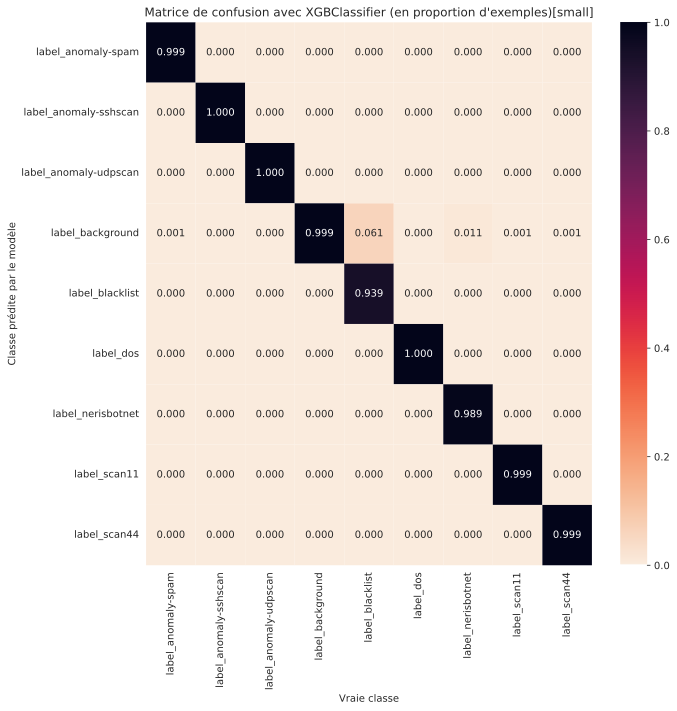

model_name='XGBClassifier' | accuracy=0.9949305555555555 | f1=0.9949305555555555 | auroc=0.9952186213991769


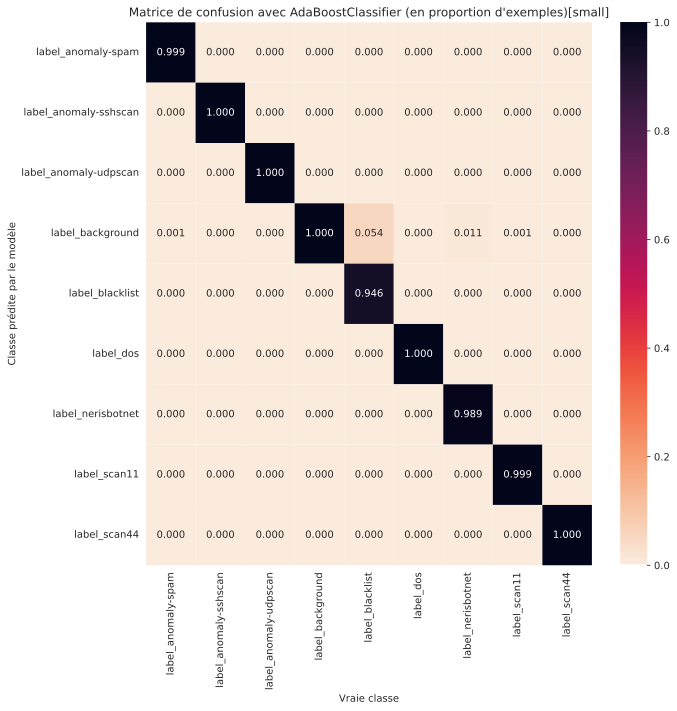

model_name='AdaBoostClassifier' | accuracy=0.9956944444444444 | f1=0.9956944444444444 | auroc=0.9957520576131687


In [304]:
performance_list = []
progress = tqdm(model_dict.items())
for model_name, model in progress:
    progress.set_description(model_name)
    # Train
    train_start_time = time.time()
    if model_name == "XGBClassifier":
        train_xgboost_model(model_name, model)
    else:
        train_sklearn_model(model_name, model)
    train_duration = time.time() - train_start_time

    # Test
    test_start_time = time.time()
    performance = evaluation(model_name, model)
    test_duration = time.time() - test_start_time

    performance["train_duration"] = train_duration
    performance["test_duration"] = test_duration
    performance["model_name"] = model_name

    performance_list.append(performance)
    
    accuracy = performance["accuracy_score"]
    f1 = performance["f1_score"]
    auroc = performance["roc_auc_score"]
    print(f"{model_name=} | {accuracy=} | {f1=} | {auroc=}")

In [309]:
perf_df = pd.DataFrame(performance_list)
perf_df

,accuracy_score,f1_score,roc_auc_score,precision_score,recall_score,train_duration,test_duration,model_name
0,0.990417,0.990417,0.995670,0.990417,0.990417,1.409992,1.193667,DecisionTreeClassifier
1,0.959167,0.959167,0.959473,0.959167,0.959167,11.910015,1.350260,RandomForestClassifier
2,0.846250,0.846250,0.886954,0.846250,0.846250,77.610495,1.195059,LogisticRegression
3,0.385972,0.385972,0.800398,0.385972,0.385972,0.192779,1.184129,GaussianNB
4,0.815556,0.815556,0.852504,0.815556,0.815556,2.193374,1.317286,SGDClassifier
5,0.922847,0.922847,0.932501,0.922847,0.922847,172.100845,29.104875,SVC
6,0.994931,0.994931,0.995219,0.994931,0.994931,538.895142,1.758482,XGBClassifier
7,0.995694,0.995694,0.995752,0.995694,0.995694,87.091941,1.679993,AdaBoostClassifier


In [310]:
perf_df.set_index("model_name", inplace=True)

In [311]:
perf_df

,accuracy_score,f1_score,roc_auc_score,precision_score,recall_score,train_duration,test_duration
model_name,,,,,,,
DecisionTreeClassifier,0.990417,0.990417,0.995670,0.990417,0.990417,1.409992,1.193667
RandomForestClassifier,0.959167,0.959167,0.959473,0.959167,0.959167,11.910015,1.350260
LogisticRegression,0.846250,0.846250,0.886954,0.846250,0.846250,77.610495,1.195059
GaussianNB,0.385972,0.385972,0.800398,0.385972,0.385972,0.192779,1.184129
SGDClassifier,0.815556,0.815556,0.852504,0.815556,0.815556,2.193374,1.317286
SVC,0.922847,0.922847,0.932501,0.922847,0.922847,172.100845,29.104875
XGBClassifier,0.994931,0.994931,0.995219,0.994931,0.994931,538.895142,1.758482
AdaBoostClassifier,0.995694,0.995694,0.995752,0.995694,0.995694,87.091941,1.679993


In [312]:
perf_df.to_csv(f"performance-{LEVEL}.csv")

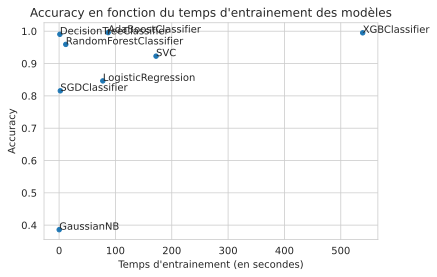

In [331]:
ax = perf_df.plot.scatter(x="train_duration", y="accuracy_score")
for i, txt in enumerate(perf_df.index):
   ax.annotate(txt, (perf_df.train_duration.iat[i]+0.05, perf_df.accuracy_score.iat[i]))
plt.title("Accuracy en fonction du temps d'entrainement des modèles")
plt.ylabel("Accuracy")
plt.xlabel("Temps d'entrainement (en secondes)")
plt.savefig("accuracy-train-duration.svg")